# Big data Storage and Processing

# Step 1: Define the Problem

### This project is to understand and classify multiclass classification of skin lesions from available dataset of 10000 dermatoscopic images, also Known as HAM10000 (Human Against Machine with 10000 training images) by using Convolutional neural network (CNN).

####  At very first before downloading the dataset i run few commands and are given below :
    -start-dfs.sh -> This command is used to start the Hadoop Distributed File System (HDFS) daemons. HDFS is the primary storage system used by Hadoop. When you execute "start-dfs.sh", it starts services such as the NameNode, DataNode, Secondary NameNode, and possibly other components depending on your Hadoop configuration. These daemons together manage the storage and retrieval of data across the cluster.
     -start-yarn.sh -> This command is used to start the Yet Another Resource Negotiator (YARN) daemons. YARN is the resource management layer in Hadoop responsible for managing compute resources and job scheduling. When you execute "start-yarn.sh", it starts services such as the ResourceManager and NodeManager. The ResourceManager is responsible for allocating resources to various applications, while the NodeManager is responsible for managing resources on individual cluster nodes.

### Secondly, I downloaded zipped image datasets that were split into two folders named HAM10000_images_part1 and HAM10000_images_part2. Additionally, a metadata file named HAM10000_metadata.tab was downloaded, containing descriptions and other details about the images.


### Thirdly, Each image file amounts to 2.8GB in size once uncompressed. I opted for gigabyte-sized files to adhere to the demands of big data storage and processing, given that Hadoop's distributed file system is utilized for storing extensive datasets. Choosing datasets of smaller sizes wouldn't yield optimal performance with Hadoop, as its minimum batch size requirement is 128MB


### At last, after unzipping the image directory, I transferred it to the Hadoop Distributed File System using the command specified under the heading 4.2. The process involved consolidating all the images into a single file named "all image," simplifying accessibility for mapping the image paths with the metadata file.

# Step 2: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from pyspark.sql.types import *
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import plotly.express as px


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Step 3: Setup Environment

In [2]:
plt.style.use('fivethirtyeight')


In [3]:
warnings.filterwarnings(action='ignore')

# Step 4: Data Collection

- Dataset Source - https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T
- Dataset consist of 3 file 
    - 1. HAM10000_images_part1.zip (5000 JPEG files)
    - 2. HAM10000_images_part2.zip (5015 JPEG files)
    - 3. HAM10000_metadata.tab (10015 rows 8 column)

### 4.1: Initializie Spark Session

In [4]:
spark = SparkSession.builder.master('local').appName('CA1SEM2IMAGECLASSIFICATION').getOrCreate()
spark

24/04/04 23:56:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### 4.2: Example path in Hadoop File System

####
    -1. Downddloaded 3 files from `(https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)`
in Download folder of linux file system where two file `HAM10000_images_part_1` and `HAM10000_images_part_2` consist of 10015 image and one file is `HAM10000_metadata.csv` which is metadata related images
they all are in zip file so unzip using linux command.

    -2. Now i created a directory at hadoop cluster to store these download file in it
        - `hadoop fs -mkdir /CA1SEM2Dataset directory using command like`
        - `hadoop fs -mkdir /CA1SEM2Dataset/all_images`
    
    -3. put `HAM10000_images_part_1`, `HAM10000_images_part_2`, `HAM10000_metadata.csv` in `CA1SEM2Dataset` directory using command like
        - `hadoop fs -put ~/Downloads/HAM10000_images_part_1 ~/CA1SEM2Dataset/`
        - `hadoop fs -put ~/Downloads/HAM10000_images_part_2 ~/CA1SEM2Dataset/`
        - `hadoop fs -put ~/Downloads/HAM10000_metadata.csv ~/CA1SEM2Dataset/`
    
    -4. copy images from part 1 and part 2 into all_images
    Hadoop command
        - `hadoop fs -cp /CA1SEM2Dataset/HAM10000_images_part_1 /CA1SEM2Dataset/all_images`
        - `hadoop fs -cp /CA1SEM2Dataset/HAM10000_images_part_2 /CA1SEM2Dataset/all_images`

    
These are ways in which i have loaded data from local directory to hadoop cluster and further i porcess data using PySpark and its library, methods, function to process the data and are given below

In [5]:

hdfs_file_path = "hdfs://localhost:9000/CA1SEM2Dataset"

### 4.3: Read CSV data into a Spark DataFrame

#### PySpark is a Python API for Apache Spark, a fast and general-purpose cluster computing system. Apache Spark is designed to handle big data processing tasks efficiently by distributing the workload across a cluster of machines. PySpark allows developers and data scientists to interact with Spark using Python, a language known for its simplicity and versatility. Here's why PySpark is commonly used in big data technology, particularly for machine learning and deep learning: And given down is way to load the dataset stored on Hadoop Distributed file system.

In [6]:
ham_metadata_df = spark.read.load(f"{hdfs_file_path}/HAM10000_metadata.csv", format="csv", header="true", sep=",", inferSchema=True)


In [7]:
ham_metadata_df.show()

+-----------+------------+---+-------+---+------+---------------+------------+
|  lesion_id|    image_id| dx|dx_type|age|   sex|   localization|     dataset|
+-----------+------------+---+-------+---+------+---------------+------------+
|HAM_0000118|ISIC_0027419|bkl|  histo| 80|  male|          scalp|vidir_modern|
|HAM_0000118|ISIC_0025030|bkl|  histo| 80|  male|          scalp|vidir_modern|
|HAM_0002730|ISIC_0026769|bkl|  histo| 80|  male|          scalp|vidir_modern|
|HAM_0002730|ISIC_0025661|bkl|  histo| 80|  male|          scalp|vidir_modern|
|HAM_0001466|ISIC_0031633|bkl|  histo| 75|  male|            ear|vidir_modern|
|HAM_0001466|ISIC_0027850|bkl|  histo| 75|  male|            ear|vidir_modern|
|HAM_0002761|ISIC_0029176|bkl|  histo| 60|  male|           face|vidir_modern|
|HAM_0002761|ISIC_0029068|bkl|  histo| 60|  male|           face|vidir_modern|
|HAM_0005132|ISIC_0025837|bkl|  histo| 70|female|           back|vidir_modern|
|HAM_0005132|ISIC_0025209|bkl|  histo| 70|female|   

In [8]:
ham_metadata_df.printSchema()

root
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)
 |-- dataset: string (nullable = true)



# Step 5: Dataset Information

- The HAM10000 dataset is a collection of roughly 10K images of skin lesions for skin cancer detection. And it has these following features:-
    - `lesion_id`: It refers to the patient linked with the skin lesion and follows the format HAM_X, where X represents a unique 7-digit identifier number. Multiple skin lesions may originate from the same patient.
    - `image_id`: refers to the name of the image within the HAM10000allimage data directories and follows the format ISIC_X, where X denotes a unique 7-digit identifier number assigned to each image. This ID is valuable for locating the image within the data directory.
    - `dx`: this refers to the diagnosis; the column uses the following abbreviation scheme:
        - `akiec`: atinic keratoses and intraepithelial carcinoma
        - `bcc`: basal cell carcinoma
        - `bkl`: benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)
        - `df`: dermatofibroma
        - `mel`: melanoma
        - `nv`: melanocytic nevi
        - `vasc`: vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)
    - `dx_type`: This indicates how the skin lesion is confirmed, which can be histopathology (abbreviated as histo), confocal, consensus, or follow-up. Further details on verification methods are available here.

    - `age`: This denotes the age of the patient linked to the skin lesion image.

    - `sex`: This signifies the gender of the patient associated with the skin lesion image, categorized as male, female, or unknown.

    - `localization`: This describes the specific location of the skin lesion on the body, such as back, hand, scalp, etc.

    - `dataset`: This identifies the original dataset from which the skin lesion was obtained, indicating the site or group it was collected from.
    
<br>
<br>

- Datatype of age feature is `float64` and rest all 7 features has object datatype
- This dataset has 10015 rows of metadata and  images 

# Step 6: Faild to Manipulte dataset over Hadoop filesystem using PySpark framework from Jupyter notebook.

### Aim to handle dataset on Hadoop file system
- I loaded two directory of images called `HAM10000_images_part1 (5000 JPEG files)` and `HAM10000_images_part2 (5015 JPEG files)` along metadata file `HAM10000_metadata.csv (10015 rows 8 column)`.
- I tried to Merge two image directory in one `all_images` directory so that i can map the path of image with HAM10000_metadata.csv based on `image_id`.

### But failed to so i Tried multiple of way to handle files over hadoop from PySpark as per document provided by Spark but didn't reaced out my desired outcome. So, i tried to merged  directory  and map image path by storing data in local directory and later on i put it on hadoop after pre-processing images directory.

### I tried multiple of ways but out of all one  examples are give below that i tried to manupulate directory but it ends with error.


In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import input_file_name
from PIL import Image
import io


# Path to the directories containing images
image_dir1 = "hdfs://localhost:9000/CA1SEM2Dataset/HAM10000_images_part_1"
image_dir2 = "hdfs://localhost:9000/CA1SEM2Dataset/HAM10000_images_part_2"

# Load images from directory 1 into DataFrame
image_df1 = spark.read.format("binaryFile").load(image_dir1)

# Add a column to indicate the source directory
image_df1 = image_df1.withColumn("source_directory", input_file_name())

# Load images from directory 2 into DataFrame
image_df2 = spark.read.format("binaryFile").load(image_dir2)
# Add a column to indicate the source directory
image_df2 = image_df2.withColumn("source_directory", input_file_name())

# Concatenate the DataFrames
merged_df = image_df1.union(image_df2)

# Show the DataFrame schema and a few rows
merged_df.printSchema()
merged_df.show()

# Write the merged DataFrame back to Hadoop
output_dir = "hdfs://localhost:9000/CA1SEM2Dataset/all_image"
# merged_df.write.format("binaryFile").option("path", output_dir).save()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- source_directory: string (nullable = false)



+--------------------+--------------------+------+--------------------+--------------------+
|                path|    modificationTime|length|             content|    source_directory|
+--------------------+--------------------+------+--------------------+--------------------+
|hdfs://localhost:...|2024-03-13 16:14:...|459172|[FF D8 FF DB 00 4...|hdfs://localhost:...|
|hdfs://localhost:...|2024-03-13 16:19:...|447988|[FF D8 FF DB 00 4...|hdfs://localhost:...|
|hdfs://localhost:...|2024-03-13 16:17:...|433820|[FF D8 FF DB 00 4...|hdfs://localhost:...|
|hdfs://localhost:...|2024-03-13 16:17:...|428827|[FF D8 FF DB 00 4...|hdfs://localhost:...|
|hdfs://localhost:...|2024-03-13 16:14:...|425055|[FF D8 FF DB 00 4...|hdfs://localhost:...|
|hdfs://localhost:...|2024-03-13 16:17:...|419981|[FF D8 FF DB 00 4...|hdfs://localhost:...|
|hdfs://localhost:...|2024-03-13 16:12:...|414082|[FF D8 FF DB 00 4...|hdfs://localhost:...|
|hdfs://localhost:...|2024-03-13 16:17:...|413458|[FF D8 FF DB 00 4...

# Step 7: Exploratory Data Analysis (EDA)

## 7.1: Convert PySpark DataFrame to pandas_on_Spark Dataframe

In [10]:
ham_ps_df = ps.DataFrame(data=ham_metadata_df)
ham_ps_df.head()


lesion_id      image_id   dx dx_type  age   sex localization       dataset
0  HAM_0000118  ISIC_0027419  bkl   histo   80  male        scalp  vidir_modern
1  HAM_0000118  ISIC_0025030  bkl   histo   80  male        scalp  vidir_modern
2  HAM_0002730  ISIC_0026769  bkl   histo   80  male        scalp  vidir_modern
3  HAM_0002730  ISIC_0025661  bkl   histo   80  male        scalp  vidir_modern
4  HAM_0001466  ISIC_0031633  bkl   histo   75  male          ear  vidir_modern

#### 7.2: Rename column name dx --> label and dx_type --> label_type

In [11]:
ham_ps_df.rename(columns={"dx":"label", "dx_type":"label_type"}, inplace=True)

#### 7.3: Check missing value

In [12]:
ham_ps_df.isna().sum()


lesion_id        0
image_id         0
label            0
label_type       0
age             57
sex              0
localization     0
dataset          0
dtype: int64

 #### Only age column has 57 missing value

#### 7.4: Check Duplicated value

In [13]:
ham_ps_df.duplicated().sum()

0

 #### No Duplicate value 

#### 7.5: Check unique value

In [14]:
ham_ps_df.nunique()

lesion_id        7470
image_id        10015
label               7
label_type          4
age                18
sex                 3
localization       15
dataset             4
dtype: int64

#### Unique Category of label_type

In [15]:
ham_ps_df['label_type'].unique()

0     confocal
1    consensus
2        histo
3    follow_up
Name: label_type, dtype: object

### Unique Category of lable

In [16]:
ham_ps_df['label'].unique()

0     vasc
1       nv
2      mel
3      bcc
4       df
5      bkl
6    akiec
Name: label, dtype: object

#### Unique Category of Age Group

In [17]:
ham_ps_df['age'].unique()

0     85.0
1     65.0
2      NaN
3     40.0
4     20.0
5      5.0
6     15.0
7     35.0
8     55.0
9     10.0
10    50.0
11    45.0
12    80.0
13    25.0
14    70.0
15    60.0
16    75.0
17    30.0
18     0.0
Name: age, dtype: float64

#### Unique Category of Sex

In [18]:
ham_ps_df['sex'].unique()

0    unknown
1     female
2       male
Name: sex, dtype: object

#### Unique Category of localization

In [19]:
ham_ps_df['localization'].unique()

0             abdomen
1               chest
2                hand
3                back
4                face
5             unknown
6             genital
7               trunk
8                foot
9                 ear
10               neck
11    upper extremity
12              scalp
13              acral
14    lower extremity
Name: localization, dtype: object

#### Unique Category of dataset

In [20]:
ham_ps_df['dataset'].unique()

0      vienna_dias
1     vidir_modern
2        rosendahl
3    vidir_molemax
Name: dataset, dtype: object

#### 7.6: Statistics of dataset

In [21]:
ham_ps_df.describe()

age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

#### From above statistical description for age
- Total count is `9958` and from above `57` missing. All together `10015`
- `mean` is `51.86` which is very close to `Median(50%) i.e 50`. Hence it shows age distribution is relatively symmetric and heavily skewed by outliers
- standard deviation `(std) is 16.96`. It shows average deviation of each data point from the mean of the dataset.
    - Most of the age `(about 68%)` fall within one Standard Deviation `(16.97)` of the mean age `(51.86)`.
    - Roughly `95%` of the ages fall with in two standar deviation of the mean.
    - Approximately `99.7%` of the ages fall within three standar deviation of the mean.
- `min` age is 0.0 and `max` age is 85.00
    

#### From above statistical description missing age can be fill with either mean or median. Here i  will use Median to fill missing value



#### 7.7 Histogram And Kernel Distribution Function (KDE)

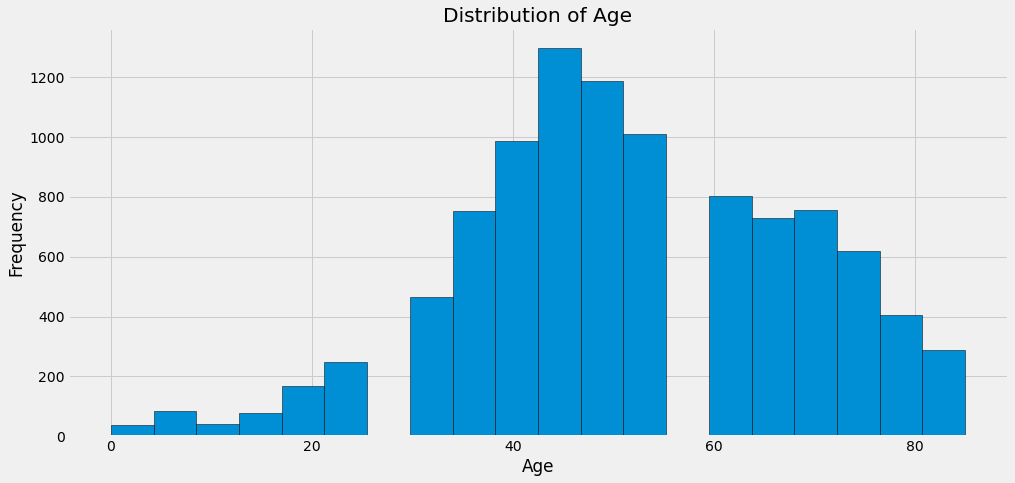

In [22]:

fig, axs = plt.subplots(1, figsize=(15,7))
plt.hist(ham_ps_df['age'], bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 7.8: Sample collected by Gender and Age

In [23]:
count_by_sex = ham_ps_df.groupby(['sex']).size().sort_values(ascending=True).reset_index(name='sex_count')
count_by_sex

sex  sex_count
0  unknown         57
1   female       4552
2     male       5406

In [24]:
gender_value = count_by_sex['sex_count'].values
gender_label = count_by_sex['sex'].values
print(gender_value)
print(gender_label)

[  57 4552 5406]
['unknown' 'female' 'male']


#### 7.8.1: Sample collected by Gender

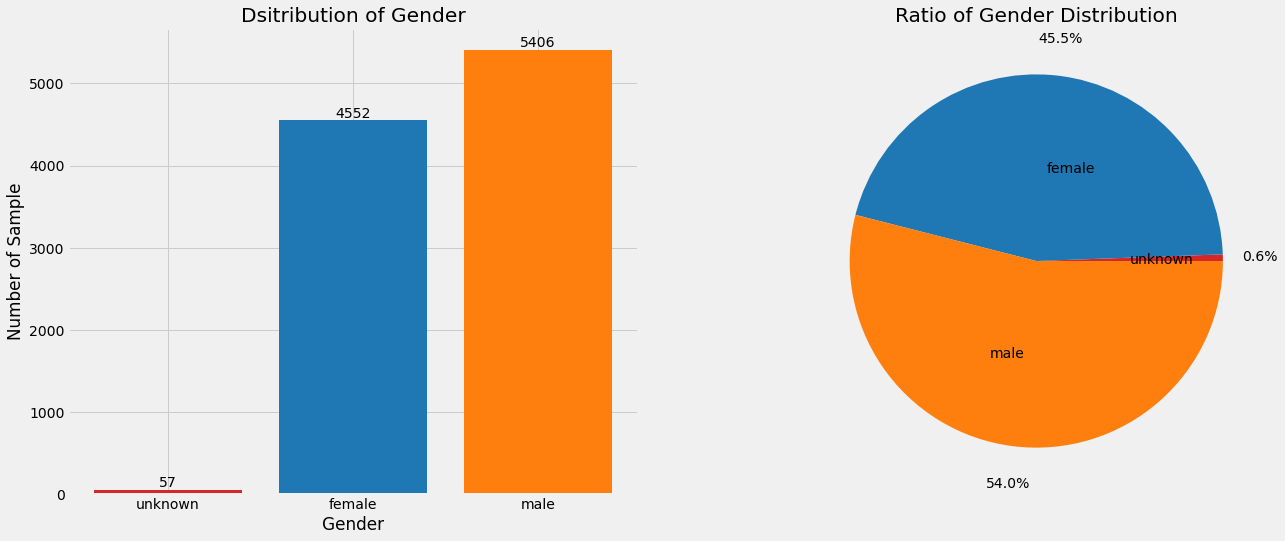

In [25]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121)
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']
bar = plt.bar(gender_label, gender_value, label=gender_label, color=bar_colors)
ax1.bar_label(bar)
ax1.set_ylabel('Number of Sample')
ax1.set_xlabel('Gender')
ax1.set_title('Dsitribution of Gender')

ax2 = plt.subplot(122)
plt.pie(gender_value, 
       labels=gender_label, 
       autopct='%1.1f%%', 
       pctdistance=1.2, 
       colors=['tab:red', 'tab:blue', 'tab:orange'],
       labeldistance=.5)
ax2.set_title('Ratio of Gender Distribution')
plt.show()

#### 7.8.2: Sample collected by Age

In [26]:
count_by_age = ham_ps_df.groupby(['age']).size().sort_values(ascending=True).reset_index(name='age_count')
count_by_age['age'].fillna('unknown',inplace=True)

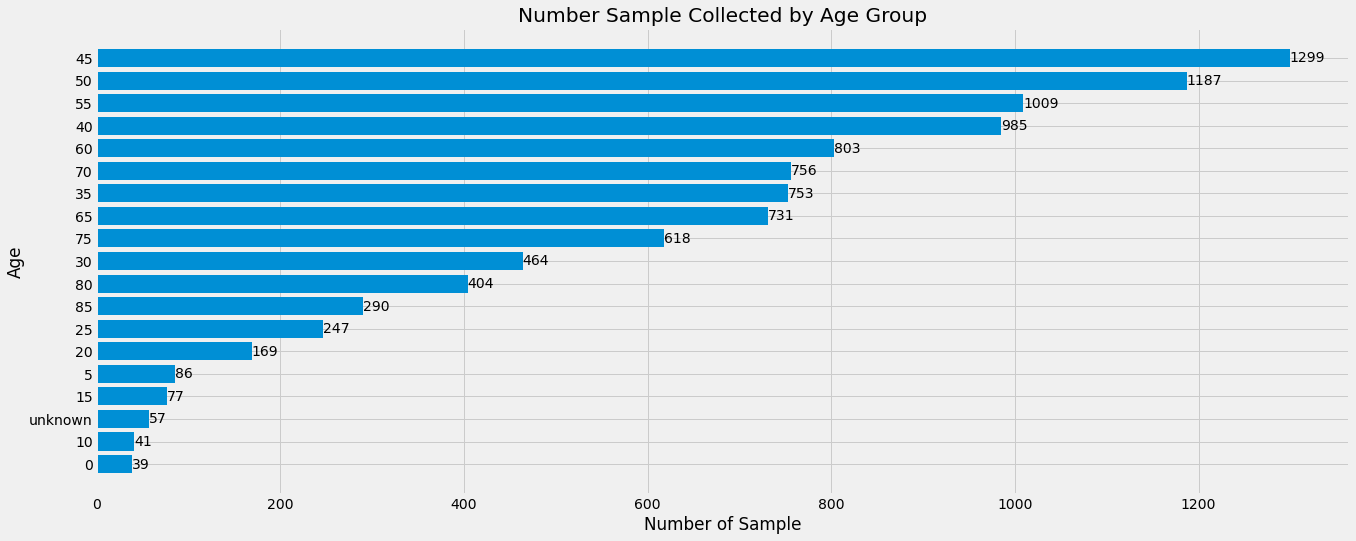

In [27]:
plt.figure(figsize=(20,8))
ax3 = plt.subplot()
hbar = plt.barh(count_by_age['age'].values, count_by_age['age_count'].values, label=count_by_age['age'].values)
# ax3.bar_label(hbar, fmt='%.2f')
ax3.bar_label(hbar)
ax3.set_xlabel('Number of Sample')
ax3.set_ylabel('Age')
ax3.set_title('Number Sample Collected by Age Group')
plt.show()

### 7.9: Box plot to see outliers

In [28]:
ham_ps_df['age'].plot.box()  

#### Here 0-5 age group is to be consider as outliers (Min outliers)

### 7.10: Distribution of Localization

In [29]:
count_by_local = ham_ps_df.groupby(['localization']).size().sort_values(ascending=True).reset_index(name='value')
count_by_local

localization  value
0             acral      7
1           genital     48
2               ear     56
3              hand     90
4             scalp    128
5              neck    168
6           unknown    234
7              foot    319
8             chest    407
9              face    745
10          abdomen   1022
11  upper extremity   1118
12            trunk   1404
13  lower extremity   2077
14             back   2192

In [30]:
count_by_local.plot.barh(y='localization', x='value', title="Distribution of Localization", text_auto=True) 

### 7.11: Diagnosis (Label) Distribution

In [31]:
count_by_label = ham_ps_df.groupby(['label']).size().sort_values(ascending=False).reset_index(name='value')
count_by_label

label  value
0     nv   6705
1    mel   1113
2    bkl   1099
3    bcc    514
4  akiec    327
5   vasc    142
6     df    115

In [32]:
count_by_label.plot.bar(y='label', x='value', title="Diagnosos (Label) Distribution", color='label', text_auto=True) 

### 7.12: Diagnosis (Label Type) Distribution i.e Diagnosis verified by

In [33]:
count_by_label_type = ham_ps_df.groupby(['label_type']).size().sort_values(ascending=False).reset_index(name='value')
count_by_label_type

label_type  value
0      histo   5340
1  follow_up   3704
2  consensus    902
3   confocal     69

In [34]:
count_by_label_type.plot.bar(y='label_type', x='value', title="Diagnosos (Label Type) Distribution", color='label_type', text_auto=True) 

### 7.13: Sex by Diagnosis 

In [35]:
sex_by_diag = ham_ps_df.groupby(['label', 'sex']).size().reset_index(name='value')
sex_by_diag = sex_by_diag.to_pandas()
sex_by_diag

label      sex  value
0      nv   female   3237
1      df     male     63
2     bkl     male    626
3      nv  unknown     47
4     mel   female    424
5      df   female     52
6   akiec     male    221
7     bkl  unknown     10
8   akiec   female    106
9      nv     male   3421
10    bkl   female    463
11    bcc     male    317
12    mel     male    689
13   vasc     male     69
14   vasc   female     73
15    bcc   female    197

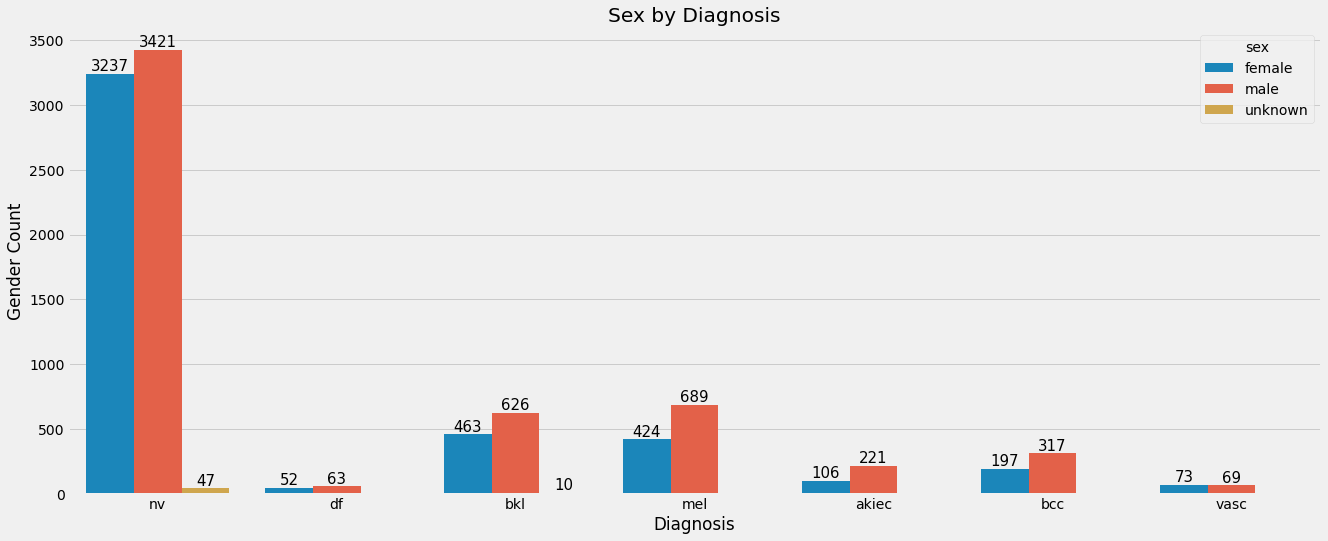

In [36]:
plt.figure(figsize=(20,8))
ax = sns.barplot(sex_by_diag, x="label", y="value", hue="sex")
for container in ax.containers:
    ax.bar_label(container, fontsize=15)
ax.set_title("Sex by Diagnosis")
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Gender Count')
plt.show()

In [37]:
fig = px.bar(sex_by_diag, x="sex", y="value", color="label", barmode='group', text_auto=True, title='Sex by Diagnosis')
fig.show()

### 7.14: Age by Diagnosis

In [38]:
label_unique = ham_ps_df['label'].unique()
age_by_diag = ham_ps_df.to_pandas()

vasc_df = age_by_diag[age_by_diag['label'] == 'vasc']
nv_df = age_by_diag[age_by_diag['label'] == 'nv']
mel_df = age_by_diag[age_by_diag['label'] == 'mel']
bcc_df = age_by_diag[age_by_diag['label'] == 'bcc']
df_df = age_by_diag[age_by_diag['label'] == 'df']
bkl_df = age_by_diag[age_by_diag['label'] == 'bkl']
akiec_df = age_by_diag[age_by_diag['label'] == 'akiec']

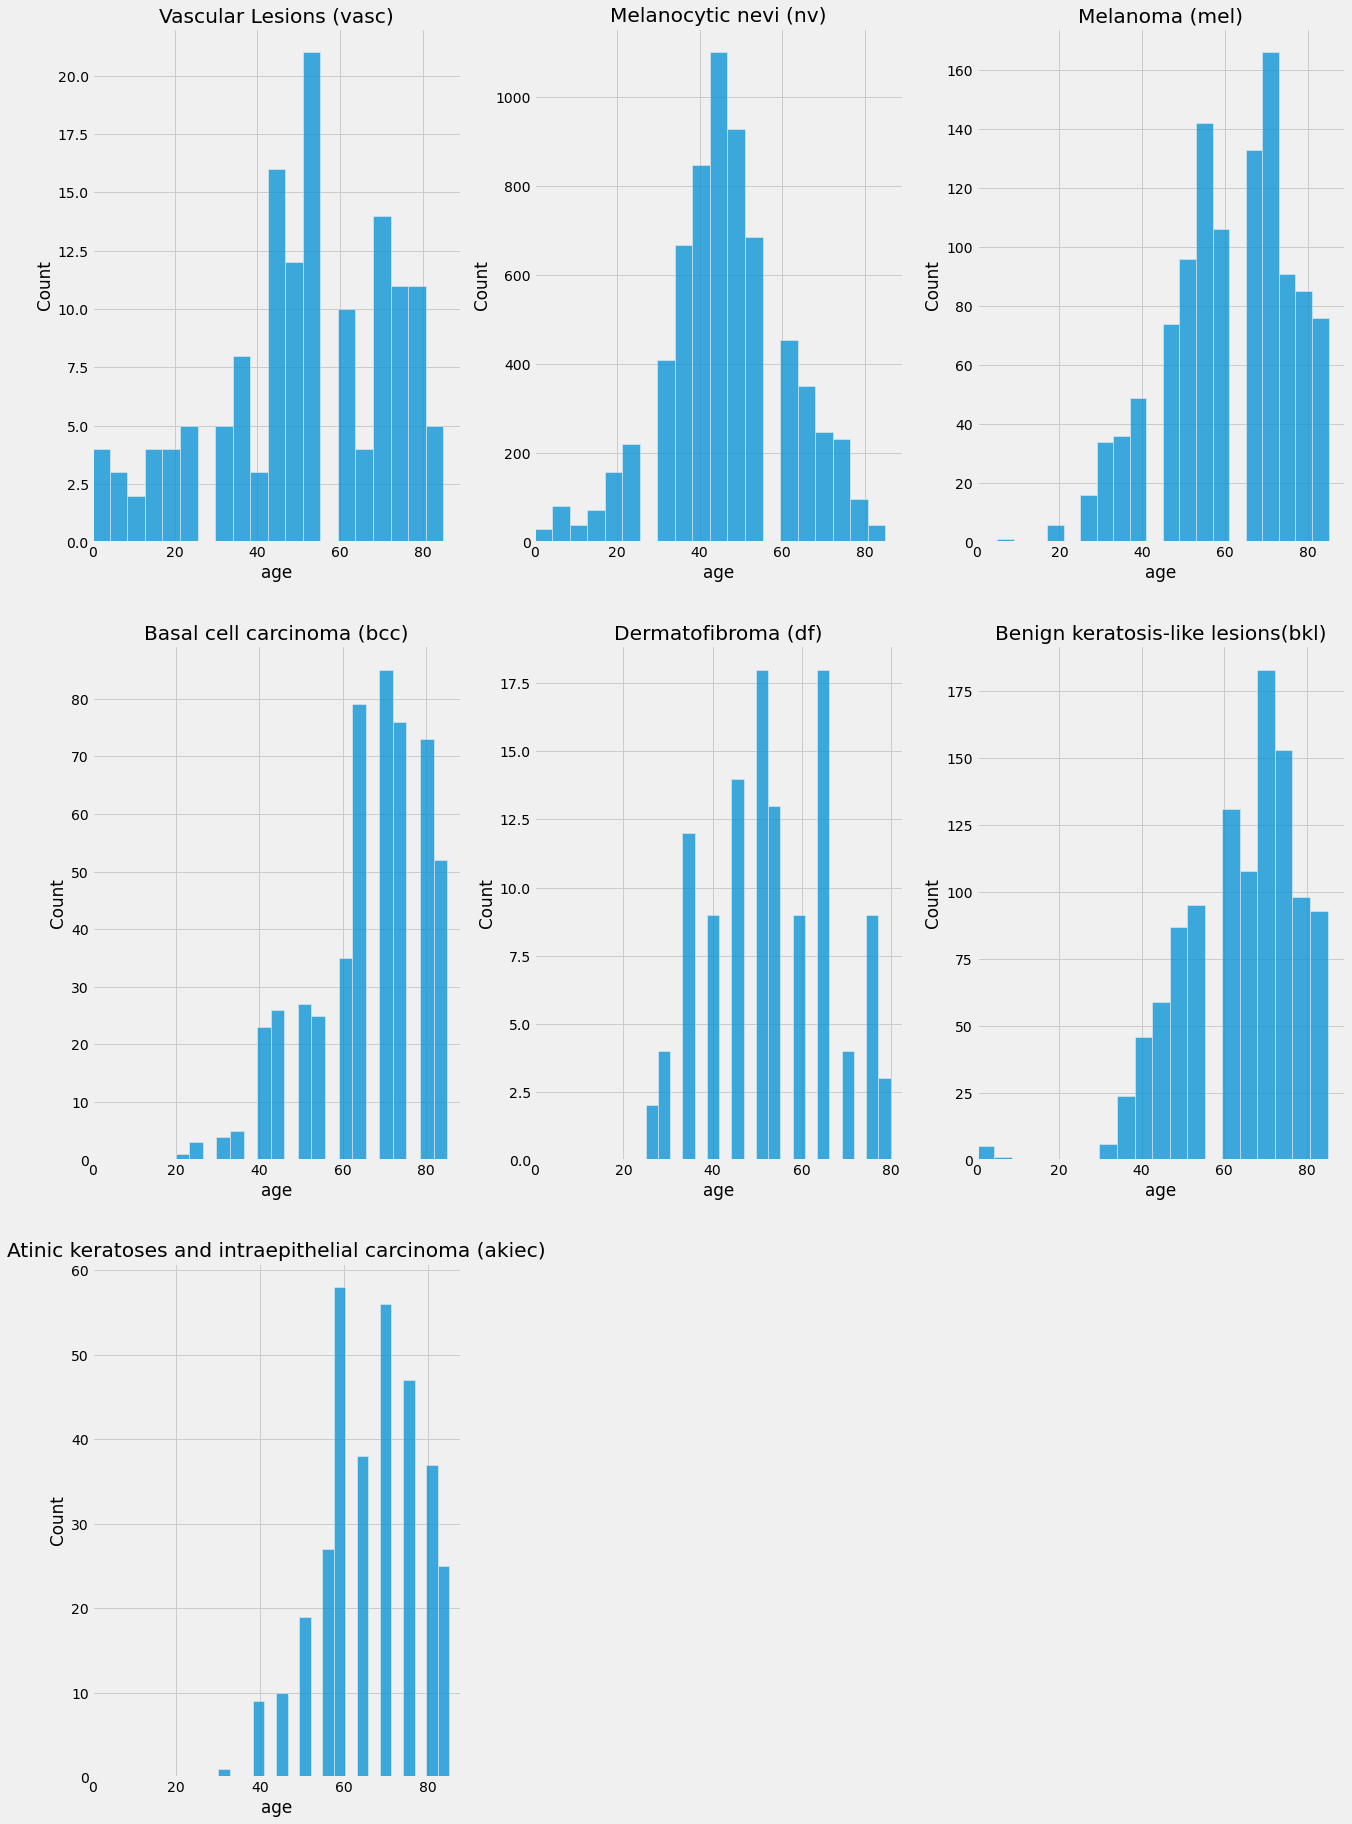

In [39]:
# Defination of function
def plot_age_by_diag(df, title):
    ax = sns.histplot(data=df, x='age', bins=20).set(title=title)
    plt.xlim(left=0)
    plt.ylim(bottom=0)

plt.figure(figsize=(20,30))

plt.subplot(3,3,1)
plot_age_by_diag(vasc_df, 'Vascular Lesions (vasc)')

plt.subplot(3,3,2)
plot_age_by_diag(nv_df, 'Melanocytic nevi (nv)')

plt.subplot(3,3,3)
plot_age_by_diag(mel_df, 'Melanoma (mel)')

plt.subplot(3,3,4)
plot_age_by_diag(bcc_df, 'Basal cell carcinoma (bcc)')

plt.subplot(3,3,5)
plot_age_by_diag(df_df, 'Dermatofibroma (df)')

plt.subplot(3,3,6)
plot_age_by_diag(bkl_df, 'Benign keratosis-like lesions(bkl)')

plt.subplot(3,3,7)
plot_age_by_diag(akiec_df, 'Atinic keratoses and intraepithelial carcinoma (akiec)')

plt.show()

In [40]:
diagn_df = ham_ps_df.groupby(['label']).size().reset_index(name='value')
fig = px.bar(diagn_df, x="label", y="value", color="label",text_auto=True, title='Diagnosis')
fig.show()

### 7.15: Localization by Diagnosis

In [41]:
loca_by_diag = ham_ps_df.groupby(['label','localization']).size().reset_index(name='value')
loca_by_diag = loca_by_diag.to_pandas()

In [42]:
vasc_df = loca_by_diag[loca_by_diag['label'] == 'vasc']
nv_df = loca_by_diag[loca_by_diag['label'] == 'nv']
mel_df = loca_by_diag[loca_by_diag['label'] == 'mel']
bcc_df = loca_by_diag[loca_by_diag['label'] == 'bcc']
df_df = loca_by_diag[loca_by_diag['label'] == 'df']
bkl_df = loca_by_diag[loca_by_diag['label'] == 'bkl']
akiec_df = loca_by_diag[loca_by_diag['label'] == 'akiec']


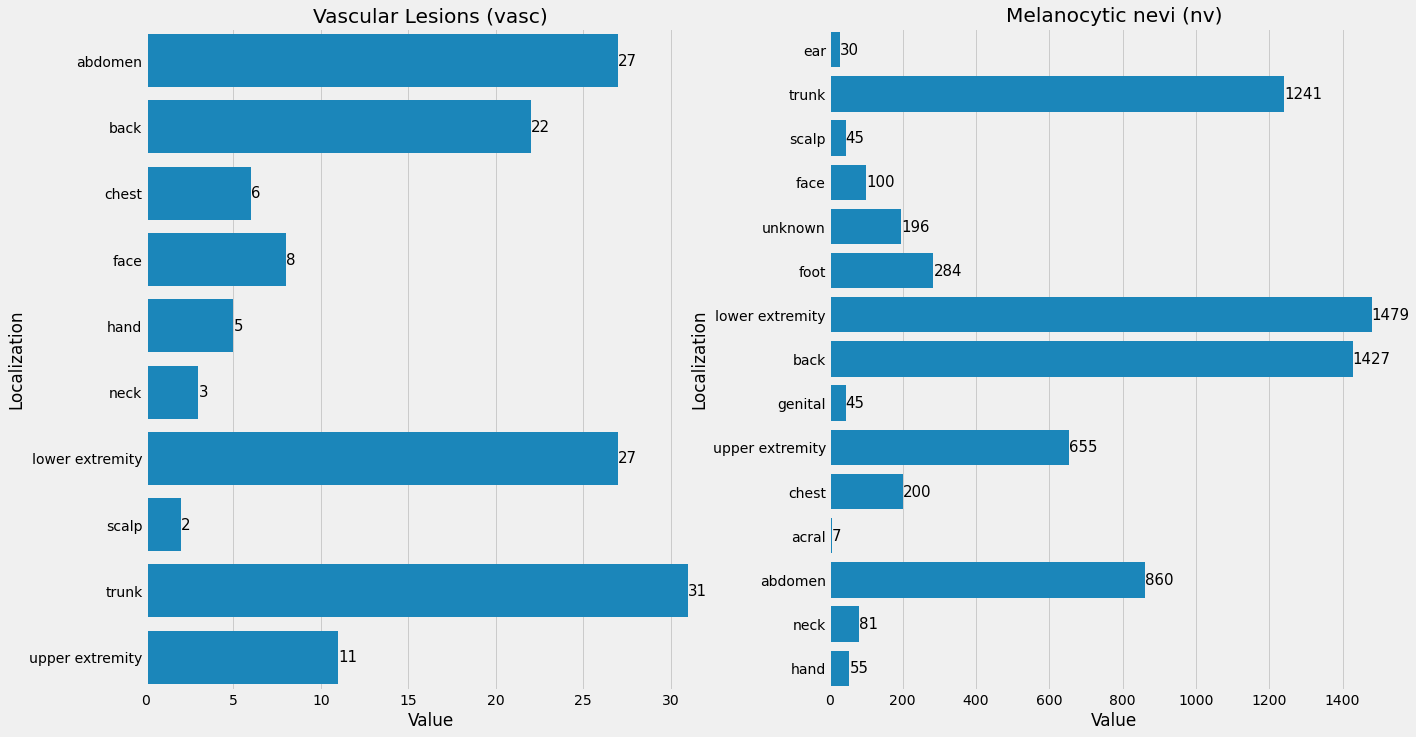

In [43]:
# Defination of function
def plot_localization_by_diag(df, title):
    ax = sns.barplot(df, y="localization", x="value")
    for container in ax.containers:
        ax.bar_label(container, fontsize=15)
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Localization')
    plt.xlim(left=0)
    
plt.figure(figsize=(20,25))
plt.title("Location of Sample Vs Value by Label")

plt.subplot(2,2,1)
plot_localization_by_diag(vasc_df,'Vascular Lesions (vasc)')

plt.subplot(2,2,2)
plot_localization_by_diag(nv_df,'Melanocytic nevi (nv)')

plt.show()

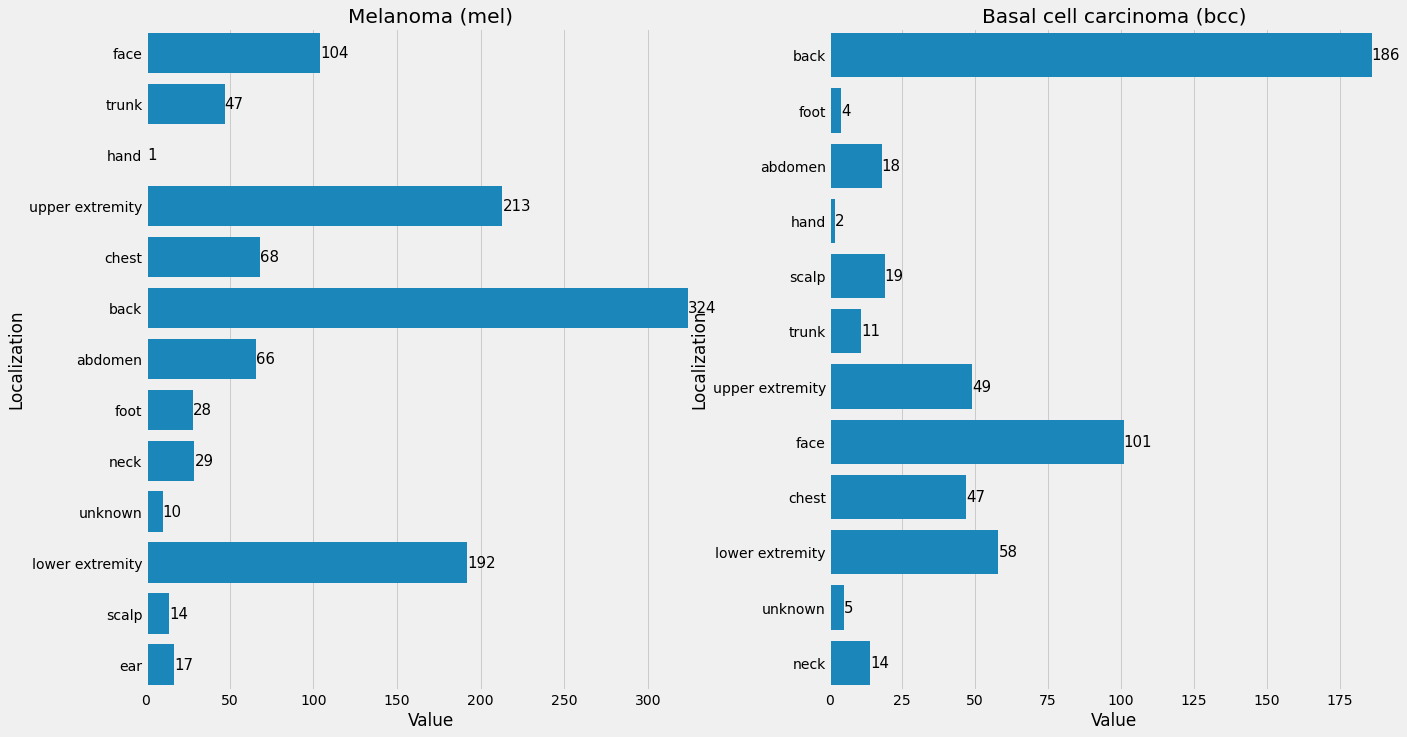

In [44]:
plt.figure(figsize=(20,25))
plt.subplot(2,2,1)
plot_localization_by_diag(mel_df,'Melanoma (mel)')

plt.subplot(2,2,2)
plot_localization_by_diag(bcc_df,'Basal cell carcinoma (bcc)')


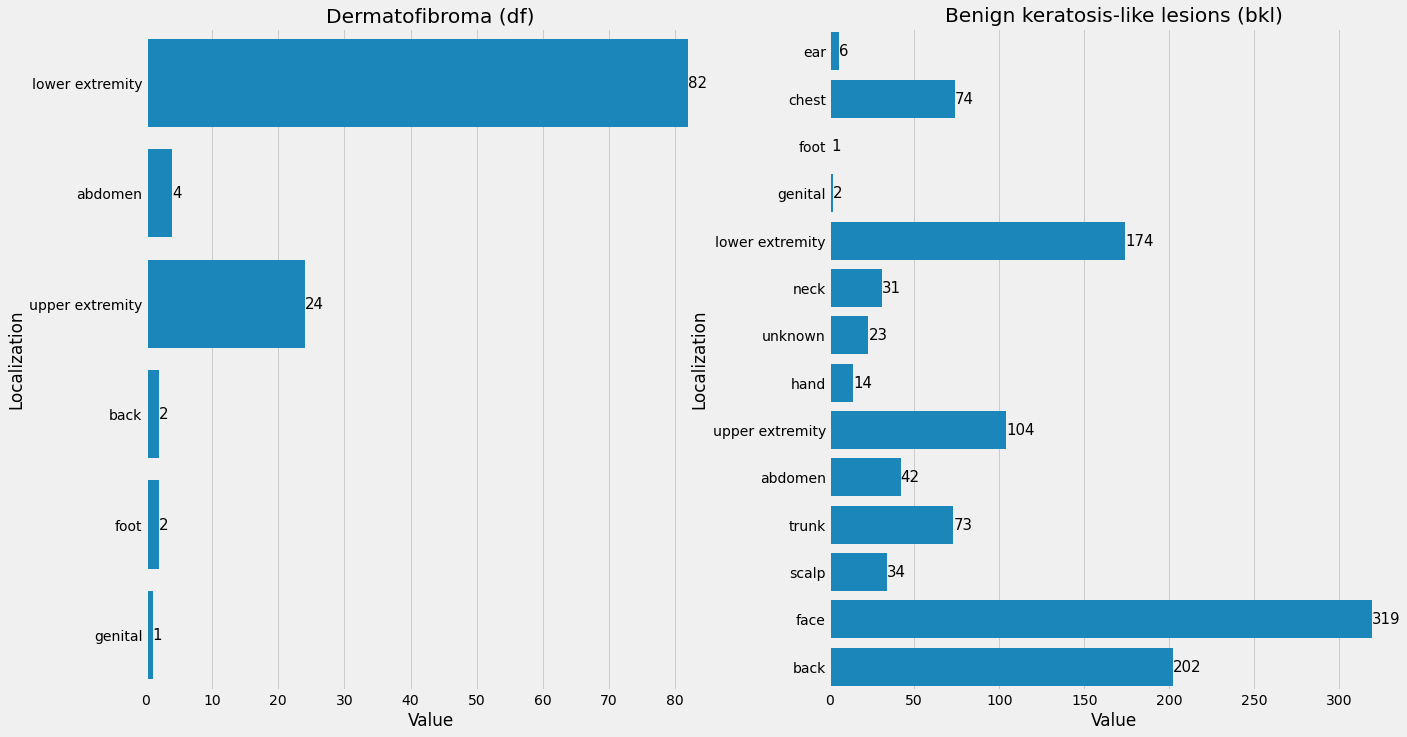

In [45]:
plt.figure(figsize=(20,25))
plt.subplot(2,2,1)
plot_localization_by_diag(df_df,'Dermatofibroma (df)')
plt.subplot(2,2,2)
plot_localization_by_diag(bkl_df,'Benign keratosis-like lesions (bkl)')


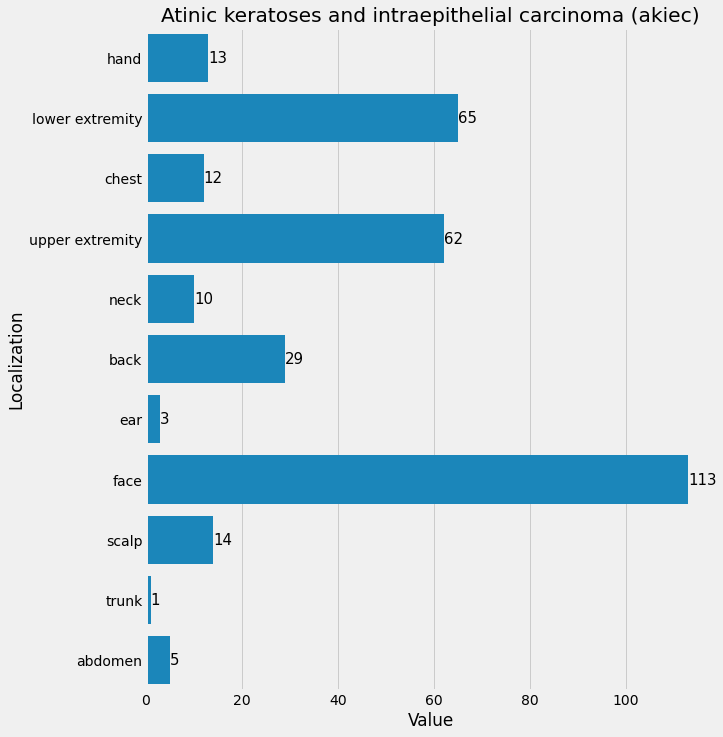

In [46]:
plt.figure(figsize=(20,25))
plt.subplot(2,2,1)
plot_localization_by_diag(akiec_df,'Atinic keratoses and intraepithelial carcinoma (akiec)')

In [47]:
localiz_df = ham_ps_df.groupby(['localization']).size().reset_index(name='value')
fig = px.bar(localiz_df, x="localization", y="value", color="localization",text_auto=True, title='Localization of Diagnosis')
fig.show()

#### 7.16: Label Type by Daignosis

In [48]:
label_type_diagnosis = ham_ps_df.groupby(['label_type']).size().reset_index(name='value')
label_type_diagnosis

label_type  value
0   confocal     69
1  consensus    902
2      histo   5340
3  follow_up   3704

In [49]:
fig = px.pie(label_type_diagnosis, values='value', names='label_type', title='Label Type by Diagnosis')
fig.show()

# Advance Data Analytics

### Step 8: Feature Engineering

In [50]:
import os
import shutil

In [51]:
# Dump all images into a folder and specify the path
image_dir = os.getcwd()+'/datasets/all_images/'

#path to destination directory where i want subfolders
dest_dir = os.getcwd()+'/datasets/organized_images/'
print(image_dir)
print(dest_dir)

/home/hduser/Desktop/CA1_SEM2_Image_Classification_CNN/datasets/all_images/
/home/hduser/Desktop/CA1_SEM2_Image_Classification_CNN/datasets/organized_images/


In [52]:
print('Image metadata loaded from Hadoop to PySpark Dataframe \n',ham_metadata_df.show(5))
print('Image metadata converted from PySpark DataFrame to Pandas on Spark Dataframe\n',ham_ps_df.head())


+-----------+------------+---+-------+---+----+------------+------------+
|  lesion_id|    image_id| dx|dx_type|age| sex|localization|     dataset|
+-----------+------------+---+-------+---+----+------------+------------+
|HAM_0000118|ISIC_0027419|bkl|  histo| 80|male|       scalp|vidir_modern|
|HAM_0000118|ISIC_0025030|bkl|  histo| 80|male|       scalp|vidir_modern|
|HAM_0002730|ISIC_0026769|bkl|  histo| 80|male|       scalp|vidir_modern|
|HAM_0002730|ISIC_0025661|bkl|  histo| 80|male|       scalp|vidir_modern|
|HAM_0001466|ISIC_0031633|bkl|  histo| 75|male|         ear|vidir_modern|
+-----------+------------+---+-------+---+----+------------+------------+
only showing top 5 rows

Image metadata loaded from Hadoop to PySpark Dataframe 
 None
Image metadata converted from PySpark DataFrame to Pandas on Spark Dataframe
      lesion_id      image_id label label_type  age   sex localization       dataset
0  HAM_0000118  ISIC_0027419   bkl      histo   80  male        scalp  vidir_modern
1

#### 8.1: Linux and Hadoop command to copy file from source directory to destination 
##### Hadoop command
- hadoop fs -cp /CA1SEM2Dataset/HAM10000_images_part_1 /CA1SEM2Dataset/all_images
- hadoop fs -cp /CA1SEM2Dataset/HAM10000_images_part_2 /CA1SEM2Dataset/all_images

##### Linux command
- cp -r HAM10000_images_part_1/*.jpg all_images/
- cp -r HAM10000_images_part_2/*.jpg all_images/


#### Step 8.2: Display unique label and count value associated with it. So that we can seperate image based on label and copy into label specific directory inside destination  directory .ie. inside `organized_images` from `all_images` i.e source directory.

In [53]:
# labels = ham_metadata_df.select('dx').distinct().collect()
from pyspark.sql import functions as Fun
labels=ham_metadata_df.select(Fun.collect_set('dx').alias('dx')).first()['dx']
labels

['mel', 'vasc', 'bcc', 'akiec', 'df', 'nv', 'bkl']

In [54]:
# Unique Labels
labels = ham_ps_df['label'].unique().to_list()
labels

['vasc', 'nv', 'mel', 'bcc', 'df', 'bkl', 'akiec']

In [55]:
# Sort the images based on its label and placed them into specific folder based on labeled name
# label_images = []
# for i in labels:
#     os.makedirs(dest_dir+str(i) + "/", exist_ok=True)
#     sample = ham_ps_df[ham_ps_df['label'] == i]['image_id'].to_numpy()
#     label_images.extend(sample)
#     for id in label_images:
#         shutil.copyfile((image_dir + '/' + id + ".jpg"), (dest_dir + i +'/' + id + ".jpg"))
#     label_images = []

In [56]:
from PIL import Image
from glob import glob
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample


2024-04-04 23:57:59.905029: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:58:00.336048: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:58:01.348343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 23:58:04.190548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [57]:
IMAGE_SIZE = 32

#### 8.3. Label Encoding to Label column

In [58]:
ham_df = ham_ps_df.to_pandas()
label_enc = LabelEncoder()
ham_df['target_label'] = label_enc.fit_transform(ham_df['label'])

#### 8.4 Handle Data Augmentation

In [59]:
# Value Counts
print(ham_df['label'].value_counts())

label
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


#### From above dataframe we can see that `bcc`, `akiec`,`vasc`,`df` these 4 label are highly imbalanced as compared to `nv` or `mel`,`bkl`. So, here i will try to resample all the lable to 1000 each. So the each group of data is balanced to 1000.

In [60]:
ham_df_0 = ham_df[ham_df['target_label'] == 0]
ham_df_1 = ham_df[ham_df['target_label'] == 1]
ham_df_2 = ham_df[ham_df['target_label'] == 2]
ham_df_3 = ham_df[ham_df['target_label'] == 3]
ham_df_4 = ham_df[ham_df['target_label'] == 4]
ham_df_5 = ham_df[ham_df['target_label'] == 5]
ham_df_6 = ham_df[ham_df['target_label'] == 6]
ham_df_0.head(10)

lesion_id      image_id  label label_type   age     sex  \
9687  HAM_0002644  ISIC_0029417  akiec      histo  80.0  female   
9688  HAM_0006002  ISIC_0029915  akiec      histo  50.0  female   
9689  HAM_0000549  ISIC_0029360  akiec      histo  70.0    male   
9690  HAM_0000549  ISIC_0026152  akiec      histo  70.0    male   
9691  HAM_0000673  ISIC_0029659  akiec      histo  70.0  female   
9692  HAM_0006875  ISIC_0026575  akiec      histo  80.0    male   
9693  HAM_0006875  ISIC_0030586  akiec      histo  80.0    male   
9694  HAM_0005282  ISIC_0025178  akiec      histo  65.0    male   
9695  HAM_0005282  ISIC_0028730  akiec      histo  65.0    male   
9696  HAM_0006898  ISIC_0029041  akiec      histo  80.0    male   

         localization       dataset  target_label  
9687             neck  vidir_modern             0  
9688             face  vidir_modern             0  
9689  upper extremity  vidir_modern             0  
9690  upper extremity  vidir_modern             0  
9691             face     rosendahl             0  
9692             face  vidir_modern             0  
9693             face  vidir_modern             0  
9694  lower extremity     rosendahl             0  
9695  lower extremity     rosendahl             0  
9696            scalp     rosendahl             0

In [61]:
SAMPLE = 1000
df_0_balanced = resample(ham_df_0, replace=True, n_samples=SAMPLE, random_state=42)
df_1_balanced = resample(ham_df_1, replace=True, n_samples=SAMPLE, random_state=42)
df_2_balanced = resample(ham_df_2, replace=True, n_samples=SAMPLE, random_state=42)
df_3_balanced = resample(ham_df_3, replace=True, n_samples=SAMPLE, random_state=42)
df_4_balanced = resample(ham_df_4, replace=True, n_samples=SAMPLE, random_state=42)
df_5_balanced = resample(ham_df_5, replace=True, n_samples=SAMPLE, random_state=42)
df_6_balanced = resample(ham_df_6, replace=True, n_samples=SAMPLE, random_state=42)

In [62]:
# Combine to single dataframe
ham_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                             df_2_balanced, df_3_balanced,  
                             df_4_balanced, df_5_balanced, df_6_balanced]
                           )

In [63]:
print(ham_df_balanced['label'].value_counts())

label
akiec    1000
bcc      1000
bkl      1000
df       1000
mel      1000
nv       1000
vasc     1000
Name: count, dtype: int64


#### Read the images based on image id from the csv file

In [64]:
import glob
# Read the images based on image id from the csv file
image_path = {os.path.splitext(os.path.basename(x))[0]: x
for x in glob.glob(os.path.join('datasets/all_images/', '*.jpg'))}
ham_df_balanced['path'] = ham_df_balanced['image_id'].map(image_path.get)

#### Resize images into 32*32 pixel array

In [65]:
ham_df_balanced['image'] = ham_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((IMAGE_SIZE,IMAGE_SIZE))))


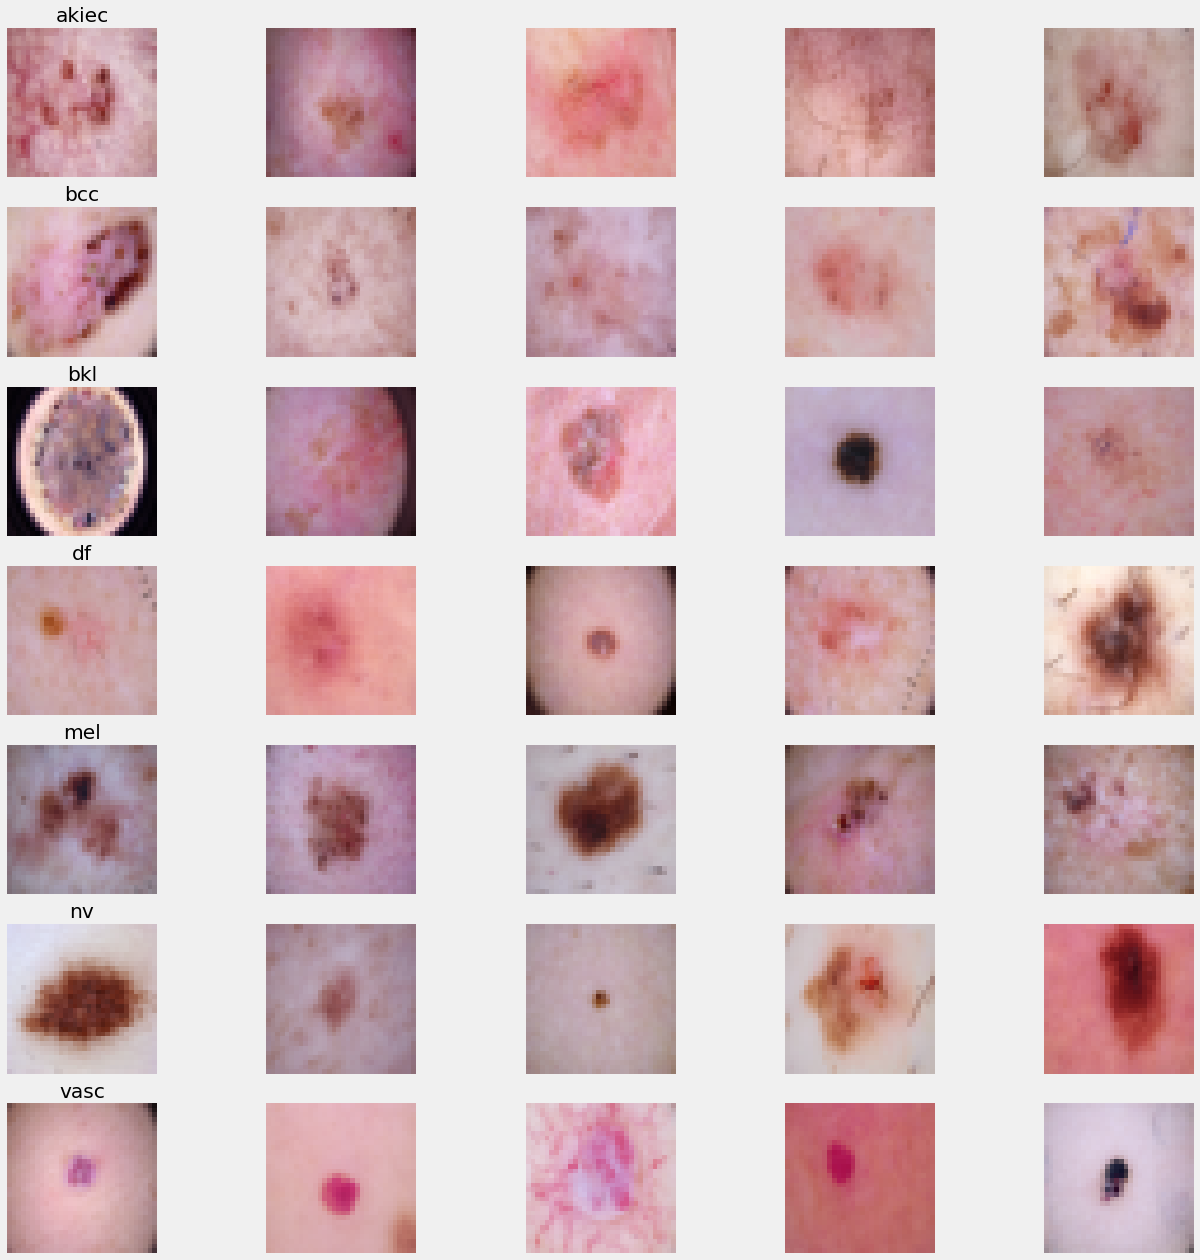

In [66]:
image_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, image_samples, figsize = (4*image_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         ham_df_balanced.sort_values(['label']).groupby('label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(image_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

#### Convert dataframe column of images into numpy array
#### Scale X value
#### Convert Y value into categorical

In [67]:
X = np.asarray(ham_df_balanced['image'].tolist())

# Scale values to 0-1.
X = X/255.

# Assign label values to Y
Y = ham_df_balanced['target_label'] 

#Convert to categorical as this is a multiclass classification problem
Y_cat = to_categorical(Y, num_classes=7) 


#### Split to training and testing

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

 #### Define the model
 ##### I've used autokeras to find out the best model for this problem.

#### model = Sequential(): This initializes a sequential model, which is a linear stack of layers. In this model, layers are added sequentially one by one.

#### Second line adds a convolutional layer (Conv2D) with 256 filters, each with a 3x3 kernel size, and ReLU activation function. It's the first layer of the network, so it also specifies the input shape of the images (IMAGE_SIZE, IMAGE_SIZE, 3) Where IMAGE_SIZE is 32 i.e 32*32 pixel.

#### Third line  adds a max-pooling layer (MaxPool2D) with a 2x2 pooling window. Max-pooling reduces the spatial dimensions of the feature maps, helping to decrease the computational complexity and control overfitting.

#### Dropout is a regularization technique used to prevent overfitting. It randomly drops a fraction of the neurons during training to force the network to learn more robust features. Here, a dropout rate of 0.3 (30%) is applied after the pooling layer.

#### This sequence of adding Conv2D, MaxPooling2D, and Dropout layers is repeated two more times with decreasing numbers of filters (128, 64) to further extract features and reduce dimensionality.

#### `model.add(Flatten()) :` This layer flattens the input, converting the multidimensional feature maps into a one-dimensional vector. This is necessary before feeding the data into fully connected layers.

#### `model.add(Dense(32)):` This adds a fully connected (dense) layer with 32 units/neurons. The dense layer is responsible for learning non-linear combinations of features extracted by the convolutional layers.

#### `model.add(Dense(7, activation='softmax')):` This adds the output layer with 7 neurons (assuming it's a multi-class classification problem with 7 classes) and applies the softmax activation function. Softmax converts the raw output scores into probabilities, where each value represents the likelihood of the input belonging to a particular class.

#### `model.summary():` This line prints a summary of the model architecture, displaying the layer types, output shapes, and the number of parameters.

#### This last line compiles the model, specifying the loss function (categorical cross-entropy because we are classifying multiclass images), optimizer (Adam), and metrics to monitor during training (accuracy). Adam optimizer is very efficient and popular among other optimizer technique.

In [69]:
# Building a linear stack of layers with the sequential model in keras
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

#### Train Model

#### `Batch Size` refers to the number of samples or data points that are processed or propagated through the neural network during a single forward and backward pass. In other words, it represents the number of training examples utilized in one iteration. When training a model, the dataset is divided into smaller batches, and each batch is processed sequentially.

    - For example, here batch_size is set to 128, it means that the model will process 128 samples at a time during each training iteration.
    
    
#### `Epochs` indicate the number of complete passes through the entire training dataset. In other words, one epoch is completed when the entire dataset has been processed forward and backward through the neural network once. During each epoch, the model learns from the entire training dataset, updating its parameters (weights and biases) based on the calculated loss and the chosen optimization algorithm (such as gradient descent).

    -For example, here epochs is set to 150, it means that the training process will iterate over the entire dataset 150 times, updating the model's parameters accordingly after each epoch

In [70]:
batch_size = 128 
epochs = 150

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_test, y_test),
    verbose=2)

score = model.evaluate(X_test, y_test)
print('Test Loss :', score[0])
print('Test Accuracy:', score[1])

Epoch 1/150


2024-04-04 23:59:20.770888: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64512000 exceeds 10% of free system memory.
2024-04-04 23:59:23.439719: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117964800 exceeds 10% of free system memory.
2024-04-04 23:59:23.606068: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29491200 exceeds 10% of free system memory.
2024-04-04 23:59:23.620202: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29491200 exceeds 10% of free system memory.
2024-04-04 23:59:23.620855: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29491200 exceeds 10% of free system memory.


42/42 - 27s - 638ms/step - acc: 0.2019 - loss: 1.9043 - val_acc: 0.2800 - val_loss: 1.8163
Epoch 2/150
42/42 - 40s - 959ms/step - acc: 0.2890 - loss: 1.7487 - val_acc: 0.2366 - val_loss: 1.7081
Epoch 3/150
42/42 - 23s - 558ms/step - acc: 0.3667 - loss: 1.5699 - val_acc: 0.3371 - val_loss: 1.7028
Epoch 4/150
42/42 - 41s - 974ms/step - acc: 0.3912 - loss: 1.5435 - val_acc: 0.4457 - val_loss: 1.4122
Epoch 5/150
42/42 - 27s - 646ms/step - acc: 0.4453 - loss: 1.3889 - val_acc: 0.4114 - val_loss: 1.5351
Epoch 6/150
42/42 - 39s - 940ms/step - acc: 0.4482 - loss: 1.3952 - val_acc: 0.2909 - val_loss: 1.9404
Epoch 7/150
42/42 - 41s - 981ms/step - acc: 0.4606 - loss: 1.4080 - val_acc: 0.3629 - val_loss: 1.5594
Epoch 8/150
42/42 - 27s - 637ms/step - acc: 0.4562 - loss: 1.3787 - val_acc: 0.4326 - val_loss: 1.4535
Epoch 9/150
42/42 - 40s - 953ms/step - acc: 0.4781 - loss: 1.3529 - val_acc: 0.4080 - val_loss: 1.5467
Epoch 10/150
42/42 - 26s - 627ms/step - acc: 0.4530 - loss: 1.3923 - val_acc: 0.4937 

Epoch 81/150
42/42 - 40s - 944ms/step - acc: 0.7907 - loss: 0.5677 - val_acc: 0.7680 - val_loss: 0.6912
Epoch 82/150
42/42 - 31s - 730ms/step - acc: 0.7665 - loss: 0.6237 - val_acc: 0.7977 - val_loss: 0.5934
Epoch 83/150
42/42 - 35s - 837ms/step - acc: 0.7956 - loss: 0.5542 - val_acc: 0.7943 - val_loss: 0.6196
Epoch 84/150
42/42 - 41s - 971ms/step - acc: 0.7827 - loss: 0.5803 - val_acc: 0.7943 - val_loss: 0.6028
Epoch 85/150
42/42 - 25s - 603ms/step - acc: 0.7910 - loss: 0.5595 - val_acc: 0.7977 - val_loss: 0.5781
Epoch 86/150
42/42 - 24s - 574ms/step - acc: 0.8074 - loss: 0.5438 - val_acc: 0.7720 - val_loss: 0.6799
Epoch 87/150
42/42 - 40s - 954ms/step - acc: 0.7455 - loss: 0.6853 - val_acc: 0.7823 - val_loss: 0.6481
Epoch 88/150
42/42 - 24s - 563ms/step - acc: 0.7813 - loss: 0.5898 - val_acc: 0.7309 - val_loss: 0.7603
Epoch 89/150
42/42 - 24s - 564ms/step - acc: 0.6971 - loss: 0.8091 - val_acc: 0.7320 - val_loss: 0.7910
Epoch 90/150
42/42 - 40s - 958ms/step - acc: 0.6992 - loss: 0.83

#### plot the training and validation accuracy and loss at each epoch

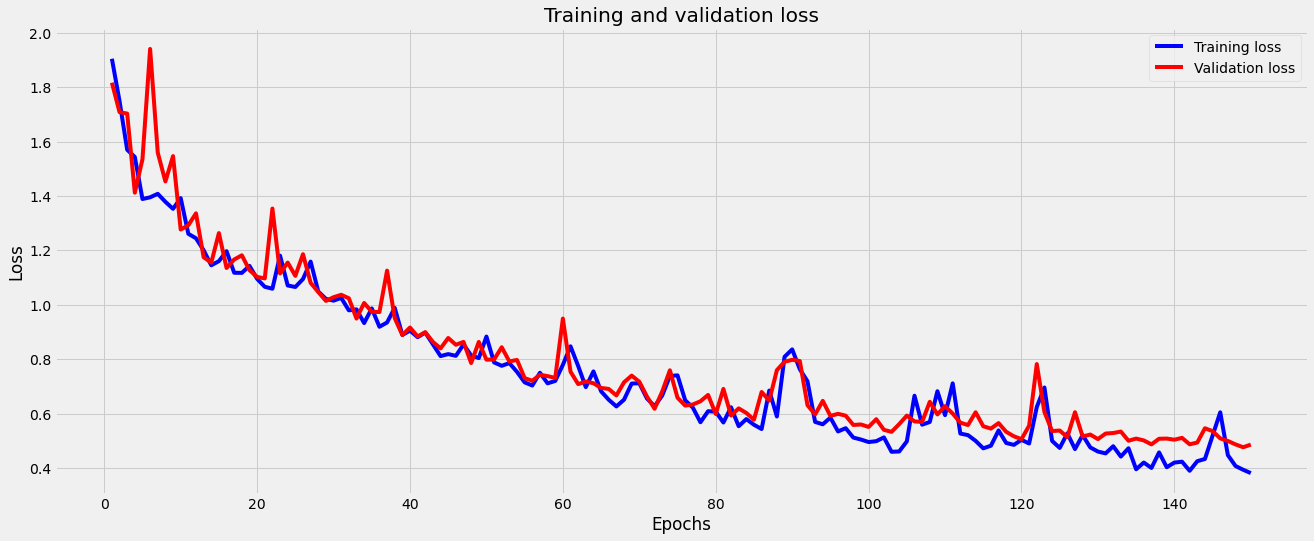

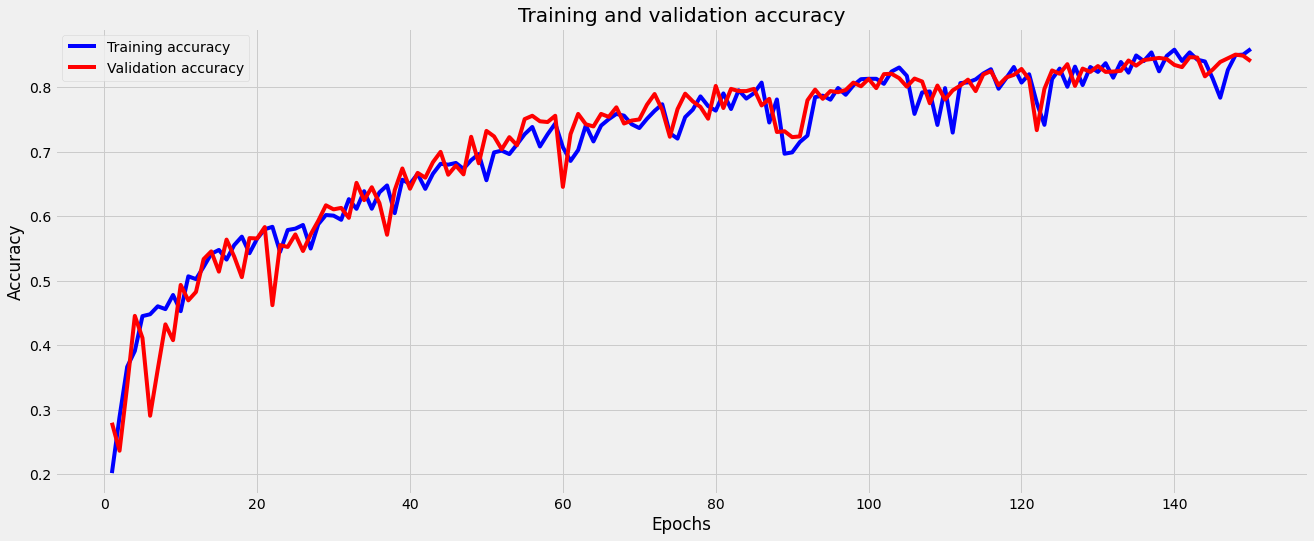

In [71]:
plt.figure(figsize=(20,8))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(20,8))
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Predict the test Data

In [72]:
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 

# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step


#### Print confusion matrix

In [73]:
cm = confusion_matrix(y_true, y_pred_classes)

#### Heat Map

<AxesSubplot:>

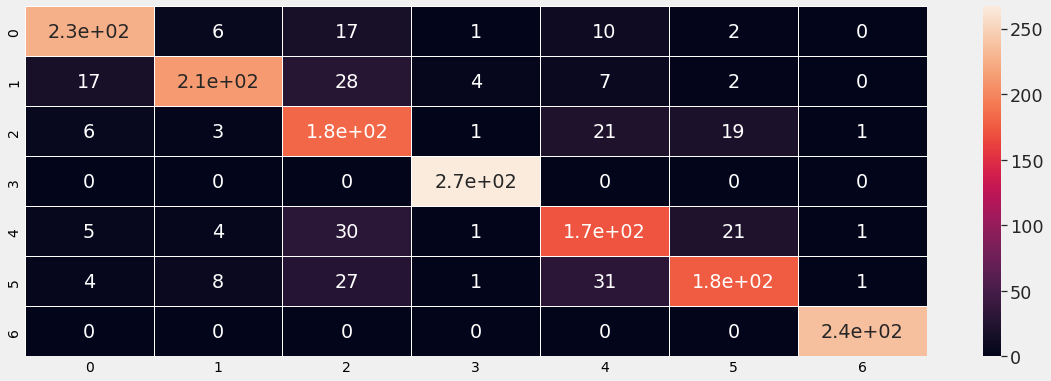

In [74]:
fig, ax = plt.subplots(figsize=(18,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

#### Plot fractional incorrect misclassifications

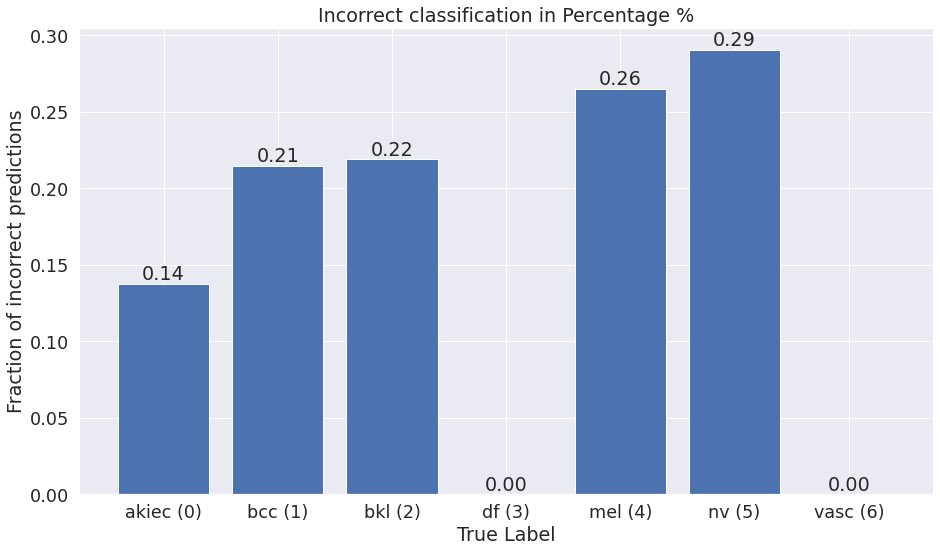

In [75]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(30,8))
labels = ['akiec (0)','bcc (1)', 'bkl (2)', 'df (3)', 'mel (4)','nv (5)', 'vasc (6)']
ax1 = plt.subplot(121)
bar = plt.bar(labels, incorr_fraction, label=labels) 
ax1.bar_label(bar, fmt='%.2f')
ax1.set_ylabel('Fraction of incorrect predictions')
ax1.set_xlabel('True Label')
ax1.set_title('Incorrect classification in Percentage %')
plt.show()

#### Classification Report

In [76]:

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       262
           1       0.91      0.79      0.84       270
           2       0.64      0.78      0.70       233
           3       0.97      1.00      0.99       267
           4       0.71      0.74      0.72       234
           5       0.80      0.71      0.75       248
           6       0.99      1.00      0.99       236

    accuracy                           0.84      1750
   macro avg       0.84      0.84      0.84      1750
weighted avg       0.85      0.84      0.84      1750



#### Tried to load image from hadoop to dispay and perform some action but end up with error and research for error but didn't come up with any solution. So i used different approach to display image and convert in to pixel to train and test model. As per mention above.

In [77]:
from PIL import Image
from io import BytesIO
from IPython.display import display


In [78]:
dfs = spark.read.format('image').load('hdfs://localhost:9000/CA1SEM2Dataset/all_images')
dfs.select("image.origin","image.height","image.width","image.mode").show()

+--------------------+------+-----+----+
|              origin|height|width|mode|
+--------------------+------+-----+----+
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
|hdfs://localhost:...|   450|  600|  16|
+--------------------+------+-----+----+
only showing top

In [79]:
# Function to display image from HDFS link
def display_image_from_hdfs(hdfs_link):
    # Read image from HDFS
    with open(hdfs_link, 'rb') as f:
        image_bytes = f.read()
    
    # Display image in Jupyter Notebook
    display(Image.open(BytesIO(image_bytes)))

# Display image from the first row of the DataFrame
display_image_from_hdfs(merged_df.select('path').first()[0])

FileNotFoundError: [Errno 2] No such file or directory: 'hdfs://localhost:9000/CA1SEM2Dataset/HAM10000_images_part_1/ISIC_0026343.jpg'

In [ ]:
from PIL import Image
image = Image.open(merged_df.select('path').first()[0])
print(image)

# Above again i tried to process image data from hadoop using PySpark to visulaise and also for further process for Deep learing in order to achive Parallel processing in context of Spark as per Guideline for assignment but end up with error `No such file or directory` I tried alot to solve this my self, done lot of research regaring this issues but due to short time period i faild to do so.

## What ever i have done to put the image and csv file on Hadoop platform its command are mention above saying how i have unzip data , read data and put data on hadoop from local directory to hadoop directory by creating seperated directory for dataset. i will Mention hadoop directory in video clip.